In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence

In [2]:
import torch
from torch.autograd import Function

class VectorQuantization(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        with torch.no_grad():
            embedding_size = codebook.size(1)
            inputs_size = inputs.size()
            inputs_flatten = inputs.view(-1, embedding_size)

            codebook_sqr = torch.sum(codebook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            # Compute the distances to the codebook
            distances = torch.addmm(codebook_sqr + inputs_sqr,
                inputs_flatten, codebook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    @staticmethod
    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
            '`VectorQuantization`. The function `VectorQuantization` '
            'is not differentiable. Use `VectorQuantizationStraightThrough` '
            'if you want a straight-through estimator of the gradient.')

class VectorQuantizationStraightThrough(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        indices = vq(inputs, codebook)
        indices_flatten = indices.view(-1)
        ctx.save_for_backward(indices_flatten, codebook)
        ctx.mark_non_differentiable(indices_flatten)

        codes_flatten = torch.index_select(codebook, dim=0,
            index=indices_flatten)
        codes = codes_flatten.view_as(inputs)

        return (codes, indices_flatten)

    @staticmethod
    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codebook = None, None

        if ctx.needs_input_grad[0]:
            # Straight-through estimator
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            # Gradient wrt. the codebook
            indices, codebook = ctx.saved_tensors
            embedding_size = codebook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                              .view(-1, embedding_size))
            grad_codebook = torch.zeros_like(codebook)
            grad_codebook.index_add_(0, indices, grad_output_flatten)

        return (grad_inputs, grad_codebook)

vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply

In [3]:
def to_scalar(arr):
    if type(arr) == list:
        return [x.item() for x in arr]
    else:
        return arr.item()

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1./K, 1./K)

    def forward(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    def straight_through(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
            dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        return z_q_x, z_q_x_bar

class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, dim, K=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            ResBlock(dim),
            ResBlock(dim),
        )

        self.codebook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            ResBlock(dim),
            ResBlock(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.codebook(z_e_x)
        return latents

    def decode(self, latents):
        z_q_x = self.codebook.embedding(latents).permute(0, 3, 1, 2)  # (B, D, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codebook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x



In [4]:
save_filename = './'
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10('data',train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('data',train=False, transform=transform)
num_channels = 3
valid_dataset = test_dataset
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128, shuffle=False, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=8, shuffle=False, drop_last=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=8, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [5]:
from tqdm import tqdm_notebook as tqdm

def train(data_loader, model, optimizer):
    tqdm_bar = tqdm(data_loader, desc=f'Training Epoch {epoch} ', total=int(len(data_loader)))
    epoch_loss = []
    for images, _ in tqdm_bar:
        images = images.to(device)
        optimizer.zero_grad()
        x_tilde, z_e_x, z_q_x = model(images)
        # Reconstruction loss
        loss_recons = F.mse_loss(x_tilde, images)
        # Vector quantization objective
        loss_vq = F.mse_loss(z_q_x, z_e_x.detach())
        # Commitment objective
        loss_commit = F.mse_loss(z_e_x, z_q_x.detach())
        loss = loss_recons + loss_vq + 1.0 * loss_commit
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    return epoch_loss

def test(data_loader, model):
    with torch.no_grad():
        loss_recons, loss_vq = 0., 0.
        for images, _ in data_loader:
            images = images.to(device)
            x_tilde, z_e_x, z_q_x = model(images)
            loss_recons += F.mse_loss(x_tilde, images)
            loss_vq += F.mse_loss(z_q_x, z_e_x)
        loss_recons /= len(data_loader)
        loss_vq /= len(data_loader)
    print("test recon loss: ",loss_recons.item(),", vq loss: ",loss_vq.item())
    return loss_recons.item(), loss_vq.item()

def generate_samples(images, model, args):
    with torch.no_grad():
        images = images.to(device)
        x_tilde, _, _ = model(images)
    return x_tilde

In [6]:
# Fixed images for Tensorboard
fixed_images, _ = next(iter(test_loader))
fixed_grid = make_grid(fixed_images, nrow=8, range=(-1, 1), normalize=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VectorQuantizedVAE(num_channels, 256, 512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


In [36]:
best_loss = -1.
train_loss = []
test_loss = []
for epoch in range(20):
    epoch_loss = train(train_loader, model, optimizer)
    train_loss.append(epoch_loss)
    print("train loss: ",np.mean(epoch_loss))
    loss, _ = test(valid_loader, model)
    test_loss.append(loss)
    if (epoch == 0) or (loss < best_loss):
        best_loss = loss
        print("model saved")
        with open('./best.pt', 'wb') as f:
            torch.save(model.state_dict(), f)

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Training Epoch 0 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  6.382494863036953
test recon loss:  0.06961944699287415 , vq loss:  1.8276015520095825
model saved


Training Epoch 1 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.8367538311902214
test recon loss:  0.067336805164814 , vq loss:  1.0156116485595703
model saved


Training Epoch 2 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  1.4229985214865115
test recon loss:  0.06590955704450607 , vq loss:  0.46619969606399536
model saved


Training Epoch 3 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.6921032196115655
test recon loss:  0.06382419914007187 , vq loss:  0.2601059377193451
model saved


Training Epoch 4 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.42065204157853675
test recon loss:  0.06229187920689583 , vq loss:  0.170797660946846
model saved


Training Epoch 5 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.2983178121354574
test recon loss:  0.06118679791688919 , vq loss:  0.12758837640285492
model saved


Training Epoch 6 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.23918877160915022
test recon loss:  0.05991366505622864 , vq loss:  0.10527469217777252
model saved


Training Epoch 7 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.20119531868059007
test recon loss:  0.057887595146894455 , vq loss:  0.08939334750175476
model saved


Training Epoch 8 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.16082561778290497
test recon loss:  0.05601907894015312 , vq loss:  0.07059962302446365
model saved


Training Epoch 9 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.13184738749890682
test recon loss:  0.0538412444293499 , vq loss:  0.05718226730823517
model saved


Training Epoch 10 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.11104548078440034
test recon loss:  0.05194399878382683 , vq loss:  0.049945443868637085
model saved


Training Epoch 11 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.09677703005959616
test recon loss:  0.049107812345027924 , vq loss:  0.04202188178896904
model saved


Training Epoch 12 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.08567400972175476
test recon loss:  0.047452524304389954 , vq loss:  0.03877994790673256
model saved


Training Epoch 13 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.08047663216548198
test recon loss:  0.04612467437982559 , vq loss:  0.03697219118475914
model saved


Training Epoch 14 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.07705474132314667
test recon loss:  0.04519304260611534 , vq loss:  0.03585292398929596
model saved


Training Epoch 15 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.07360673350903689
test recon loss:  0.04390113800764084 , vq loss:  0.03503687307238579
model saved


Training Epoch 16 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.07003379075804635
test recon loss:  0.043082356452941895 , vq loss:  0.03132816031575203
model saved


Training Epoch 17 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.06888778242842315
test recon loss:  0.04253947734832764 , vq loss:  0.030879870057106018
model saved


Training Epoch 18 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.06834979639257617
test recon loss:  0.04210733249783516 , vq loss:  0.03091469407081604
model saved


Training Epoch 19 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.06686858702308077
test recon loss:  0.04135288670659065 , vq loss:  0.02866608463227749
model saved


Training Epoch 20 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.06313300729179017
test recon loss:  0.040961477905511856 , vq loss:  0.027511386200785637
model saved


Training Epoch 21 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.061294375735399365
test recon loss:  0.040352798998355865 , vq loss:  0.026297425851225853
model saved


Training Epoch 22 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.060198536966843984
test recon loss:  0.03989562392234802 , vq loss:  0.025467414408922195
model saved


Training Epoch 23 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.05855824740227226
test recon loss:  0.039337754249572754 , vq loss:  0.024767767637968063
model saved


Training Epoch 24 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.057848969993688874
test recon loss:  0.038894083350896835 , vq loss:  0.024593573063611984
model saved


Training Epoch 25 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.05610820202304579
test recon loss:  0.03850220888853073 , vq loss:  0.023987459018826485
model saved


Training Epoch 26 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.05555213624825868
test recon loss:  0.038069840520620346 , vq loss:  0.023918339982628822
model saved


Training Epoch 27 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.054793913527141754
test recon loss:  0.0375923253595829 , vq loss:  0.023794345557689667
model saved


Training Epoch 28 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.05311538321930734
test recon loss:  0.03712056949734688 , vq loss:  0.023449299857020378
model saved


Training Epoch 29 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.05124677214628595
test recon loss:  0.03675191104412079 , vq loss:  0.02223094180226326
model saved


Training Epoch 30 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.04951914974376369
test recon loss:  0.03631242364645004 , vq loss:  0.022146116942167282
model saved


Training Epoch 31 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.048385501841602424
test recon loss:  0.03602614253759384 , vq loss:  0.022472457960247993
model saved


Training Epoch 32 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.04761184527136176
test recon loss:  0.03561938554048538 , vq loss:  0.022254955023527145
model saved


Training Epoch 33 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.04699164157366509
test recon loss:  0.035503458231687546 , vq loss:  0.022278636693954468
model saved


Training Epoch 34 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.046396359239164214
test recon loss:  0.03515392541885376 , vq loss:  0.022620387375354767
model saved


Training Epoch 35 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.046107896806105324
test recon loss:  0.03496287390589714 , vq loss:  0.02257486805319786
model saved


Training Epoch 36 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.04590569434644621
test recon loss:  0.0348377525806427 , vq loss:  0.022819537669420242
model saved


Training Epoch 37 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.04561103485962924
test recon loss:  0.03454934433102608 , vq loss:  0.023158513009548187
model saved


Training Epoch 38 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.04568952020934171
test recon loss:  0.03437250107526779 , vq loss:  0.023006126284599304
model saved


Training Epoch 39 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  0.045230441252746244
test recon loss:  0.03418399393558502 , vq loss:  0.023009778931736946
model saved


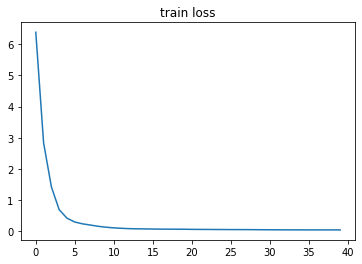

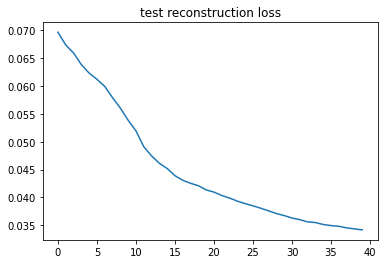

In [6]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.title("train loss")
plt.show()

plt.plot(test_loss)
plt.title("test reconstruction loss")
plt.show()

In [8]:
state_dict = torch.load("/content/drive/MyDrive/best.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
model.eval()
test_dataset = datasets.CIFAR10('data',train=False, transform=transform)
num_channels = 3
valid_dataset = test_dataset
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=8, shuffle=True, drop_last=True, pin_memory=True)
(valid_originals, _) = next(iter(valid_loader))
valid_originals = valid_originals.to(device)
valid_reconstructions = model.decoder(model.encoder(valid_originals))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


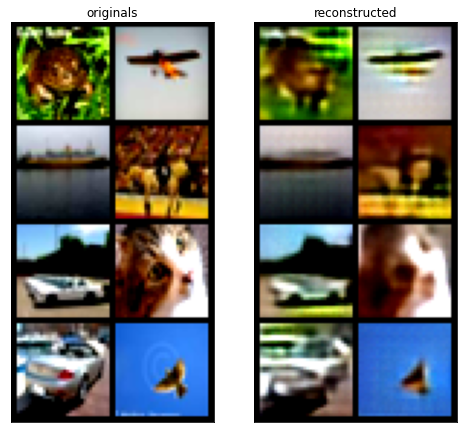

In [9]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(8,16))
ax = f.add_subplot(1,2,1)
ax.set_title("originals")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
images = (valid_originals.cpu().data)+0.5
grid = make_grid(images,nrow=2)
ax.imshow(np.transpose(grid, (1,2,0)))

ax = f.add_subplot(1,2,2)
ax.set_title("reconstructed")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
images = (valid_reconstructions.cpu().data)+0.5
grid = make_grid(images,nrow=2)
ax.imshow(np.transpose(grid, (1,2,0)))

In [13]:
class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return F.tanh(x) * F.sigmoid(y)

class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True, n_classes=10):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual

        self.class_cond_embedding = nn.Embedding(
            n_classes, 2 * dim
        )

        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)
        self.vert_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)
        self.horiz_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()  # Mask final row
        self.horiz_stack.weight.data[:, :, :, -1].zero_()  # Mask final column

    def forward(self, x_v, x_h, h):
        if self.mask_type == 'A':
            self.make_causal()

        h = self.class_cond_embedding(h)
        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert + h[:, :, None, None])

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz + h[:, :, None, None])
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h


class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15, n_classes=10):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input
        self.embedding = nn.Embedding(input_dim, dim)

        # Building the PixelCNN layer by layer
        self.layers = nn.ModuleList()

        # Initial block with Mask-A convolution
        # Rest with Mask-B convolutions
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual, n_classes)
            )

        # Add the output layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

        self.apply(weights_init)

    def forward(self, x, label):
        shp = x.size() + (-1, )
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, W)

        x_v, x_h = (x, x)
        for i, layer in enumerate(self.layers):
            x_v, x_h = layer(x_v, x_h, label)

        return self.output_conv(x_h)

    def generate(self, label, shape=(8, 8), batch_size=64):
        param = next(self.parameters())
        x = torch.zeros(
            (batch_size, *shape),
            dtype=torch.int64, device=param.device
        )

        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x, label)
                probs = F.softmax(logits[:, :, i, j], -1)
                x.data[:, i, j].copy_(
                    probs.multinomial(1).squeeze().data
                )
        return x

In [14]:
def train(data_loader, model, prior, optimizer):
    tqdm_bar = tqdm(data_loader, desc=f'Training Epoch {epoch} ', total=int(len(data_loader)))
    epoch_loss = []
    for images, labels in tqdm_bar:
        with torch.no_grad():
            images = images.to(device)
            latents = model.encode(images)
            latents = latents.detach()
        labels = labels.to(device)
        logits = prior(latents, labels)
        logits = logits.permute(0, 2, 3, 1).contiguous()
        optimizer.zero_grad()
        loss = F.cross_entropy(logits.view(-1, 512),latents.view(-1))
        loss.backward()        
        epoch_loss.append(loss.item())
        # Logs
        optimizer.step()
    return epoch_loss

def test(data_loader, model, prior):
    with torch.no_grad():
        loss = 0.
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            latents = model.encode(images)
            latents = latents.detach()
            logits = prior(latents, labels)
            logits = logits.permute(0, 2, 3, 1).contiguous()
            loss += F.cross_entropy(logits.view(-1, 512),latents.view(-1))
        loss /= len(data_loader)
    return loss.item()
prior = GatedPixelCNN(512, 64,15, n_classes=10).to(device)
optimizer = torch.optim.Adam(prior.parameters(), lr=3e-4)

Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d


In [15]:
best_loss = -1.
for epoch in range(30):
    train_loss = train(train_loader, model, prior, optimizer)
    # The validation loss is not properly computed since
    # the classes in the train and valid splits of Mini-Imagenet
    # do not overlap.
    loss = test(valid_loader, model, prior)
    print("train loss: ",np.mean(train_loss),", test loss:",loss)

    if (epoch == 0) or (loss < best_loss):
        best_loss = loss
        with open("./prior_best.pt", 'wb') as f:
            torch.save(prior.state_dict(), f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Training Epoch 0 :   0%|          | 0/391 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train loss:  3.2906487914912232 , test loss: 3.0535101890563965


Training Epoch 1 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  3.016799360894791 , test loss: 3.000246047973633


Training Epoch 2 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.973442316665064 , test loss: 2.9717795848846436


Training Epoch 3 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.9451274890119157 , test loss: 2.952317237854004


Training Epoch 4 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.9238994219114103 , test loss: 2.9382777214050293


Training Epoch 5 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.9070524285211587 , test loss: 2.9275360107421875


Training Epoch 6 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.893000422841143 , test loss: 2.9188785552978516


Training Epoch 7 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.8809187034206927 , test loss: 2.9118869304656982


Training Epoch 8 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.8703033613122027 , test loss: 2.906076431274414


Training Epoch 9 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.8608076017530983 , test loss: 2.9012086391448975


Training Epoch 10 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.852187013382192 , test loss: 2.897345542907715


Training Epoch 11 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.8442448185532903 , test loss: 2.8941726684570312


Training Epoch 12 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.836826273242531 , test loss: 2.891669750213623


Training Epoch 13 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.8298990183779043 , test loss: 2.889922857284546


Training Epoch 14 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.8233532265324115 , test loss: 2.888369560241699


Training Epoch 15 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.81713763405295 , test loss: 2.8873112201690674


Training Epoch 16 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.811234442474287 , test loss: 2.8865036964416504


Training Epoch 17 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.805540906193921 , test loss: 2.8861405849456787


Training Epoch 18 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.8000484939731294 , test loss: 2.886112928390503


Training Epoch 19 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.7947420781225802 , test loss: 2.886497735977173


Training Epoch 20 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.7896233629387663 , test loss: 2.887037515640259


Training Epoch 21 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.784625331459143 , test loss: 2.88797664642334


Training Epoch 22 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.779745352542614 , test loss: 2.8891711235046387


Training Epoch 23 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.7749887738386385 , test loss: 2.890723466873169


Training Epoch 24 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.7703036792442925 , test loss: 2.8922805786132812


Training Epoch 25 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.765716356999429 , test loss: 2.8941454887390137


Training Epoch 26 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.7612272089399643 , test loss: 2.8963418006896973


Training Epoch 27 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.756795958179952 , test loss: 2.8985795974731445


Training Epoch 28 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.7524090380314976 , test loss: 2.9010956287384033


Training Epoch 29 :   0%|          | 0/391 [00:00<?, ?it/s]

train loss:  2.7480916293990583 , test loss: 2.903865337371826


In [15]:
state_dict = torch.load("/content/drive/MyDrive/prior_best.pt")
prior.load_state_dict(state_dict)

<All keys matched successfully>

In [40]:
with torch.no_grad():
    label = torch.tensor(range(10)).to(device)
    samples = prior.generate(label=label,batch_size=10).squeeze(1).long().to(device)
    samples = model.decode(samples)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


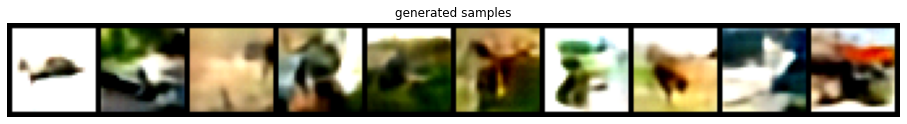

In [73]:
import matplotlib.pyplot as plt

grid_img = make_grid(samples.cpu()+0.5, nrow=10)
plt.figure(figsize=(16,8))
plt.title("generated samples")
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()